In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 120
CHANNELS = 3
EPOCHS = 40

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomatoes",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [17]:
len(dataset)

134

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(120, 256, 256, 3)
[5 9 5 6 6 0 0 7 7 2 0 9 6 2 7 9 9 1 5 7 7 1 2 4 6 0 5 7 1 4 0 5 3 7 7 0 2
 4 2 6 5 0 7 7 9 4 7 6 3 5 6 4 0 1 4 0 0 1 6 5 4 7 7 0 9 0 2 7 7 4 6 7 7 6
 9 0 4 8 5 0 7 9 5 7 5 7 9 9 3 0 4 5 4 9 7 2 2 9 7 7 2 1 7 6 5 4 0 8 6 6 7
 9 9 0 9 5 9 5 3 7]


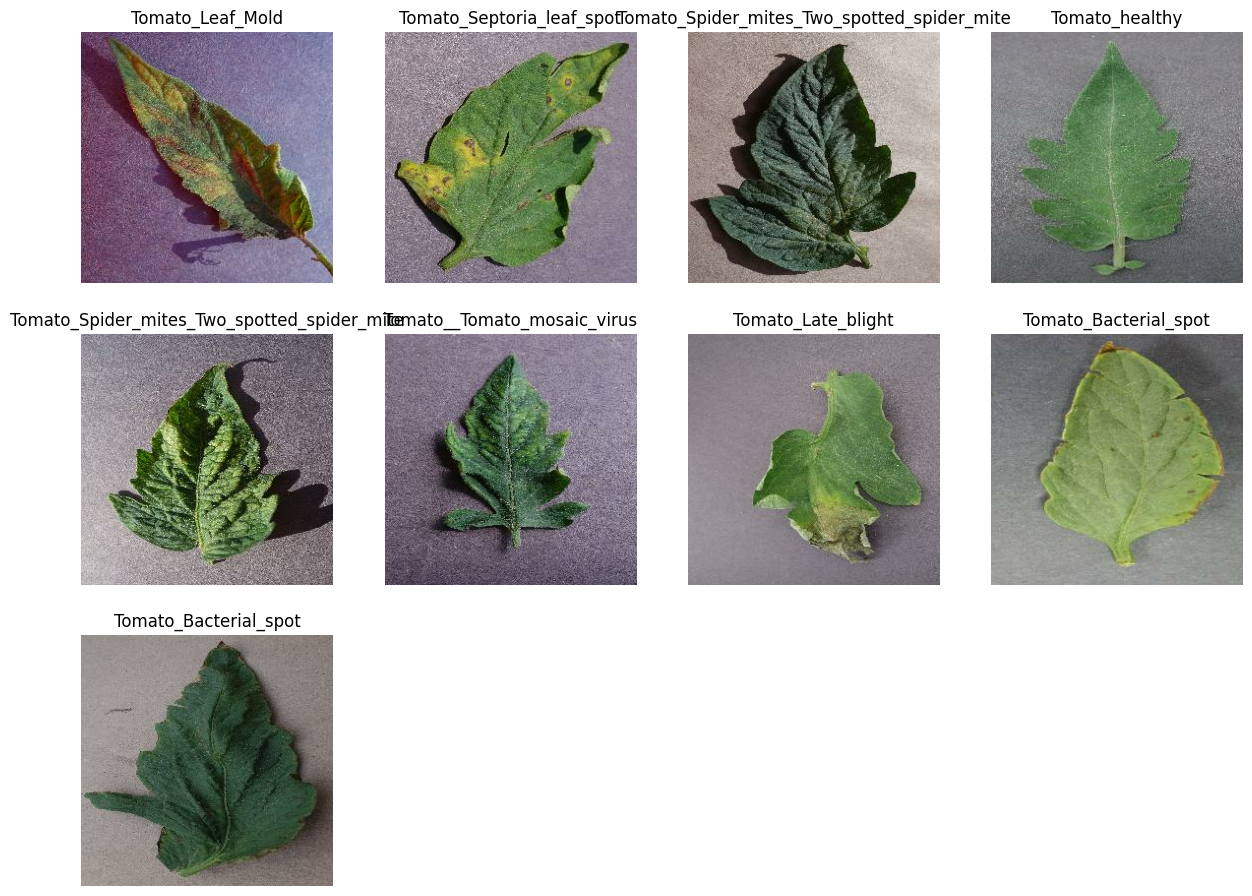

In [19]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    import math
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = math.ceil(val_split*ds_size)
    test_size = math.ceil(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

107 14 13


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


augmented_data = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(filters=40, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

c:\Users\gotze\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (120, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (120, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (120, 254, 254, 40)    │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (120, 127, 127, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (120, 125, 125, 64)    │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (120, 62, 62, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (120, 60, 60, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (120, 30, 30, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (120, 28, 28, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (120, 14, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (120, 12, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (120, 6, 6, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (120, 4, 4, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (120, 2, 2, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (120, 256)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (120, 64)              │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (120, 10)              │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,034 (738.41 KB)

 Trainable params: 189,034 (738.41 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.2606 - loss: 2.0098 - val_accuracy: 0.5256 - val_loss: 1.3329
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.5601 - loss: 1.2750 - val_accuracy: 0.6161 - val_loss: 1.1261
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.6754 - loss: 0.9240 - val_accuracy: 0.5762 - val_loss: 1.1726
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.7258 - loss: 0.7732 - val_accuracy: 0.7268 - val_loss: 0.7547
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.7939 - loss: 0.5835 - val_accuracy: 0.7232 - val_loss: 0.7764
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.8211 - loss: 0.5074 - val_accuracy: 0.7113 - val_loss: 0.8704
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.8337 - loss: 0.4707 - val_accuracy: 0.7345 - val_loss: 0.8081
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.8643 - loss: 0.3852 - val_accu

In [12]:
model.save('C:/Users/gotze/OneDrive/Desktop/Python/Deep Learning/Project/Models/Model3_Tomatoes.keras')

In [13]:
model = tf.keras.models.load_model('C:/Users/gotze/OneDrive/Desktop/Python/Deep Learning/Project/Models/Model3_Tomatoes.keras')

In [10]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (120, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (120, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (120, 254, 254, 40)    │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (120, 127, 127, 40)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (120, 125, 125, 64)    │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (120, 62, 62, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (120, 60, 60, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (120, 30, 30, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (120, 28, 28, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (120, 14, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (120, 12, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (120, 6, 6, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (120, 4, 4, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (120, 2, 2, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (120, 256)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (120, 64)              │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (120, 10)              │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,104 (2.16 MB)

 Trainable params: 189,034 (738.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 378,070 (1.44 MB)

In [14]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.9558 - loss: 0.1221 - val_accuracy: 0.8899 - val_loss: 0.4369
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 518s 5s/step - accuracy: 0.9517 - loss: 0.1355 - val_accuracy: 0.9530 - val_loss: 0.1431
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 508s 5s/step - accuracy: 0.9574 - loss: 0.1197 - val_accuracy: 0.8982 - val_loss: 0.3113
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - accuracy: 0.9561 - loss: 0.1190 - val_accuracy: 0.9524 - val_loss: 0.1379
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.9636 - loss: 0.0950 - val_accuracy: 0.9280 - val_loss: 0.2494


In [15]:
history.history['accuracy']

[0.955524206161499,
 0.9537232518196106,
 0.955524206161499,
 0.957716703414917,
 0.9660167694091797]

In [16]:
import numpy as np

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    #Create a batch
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


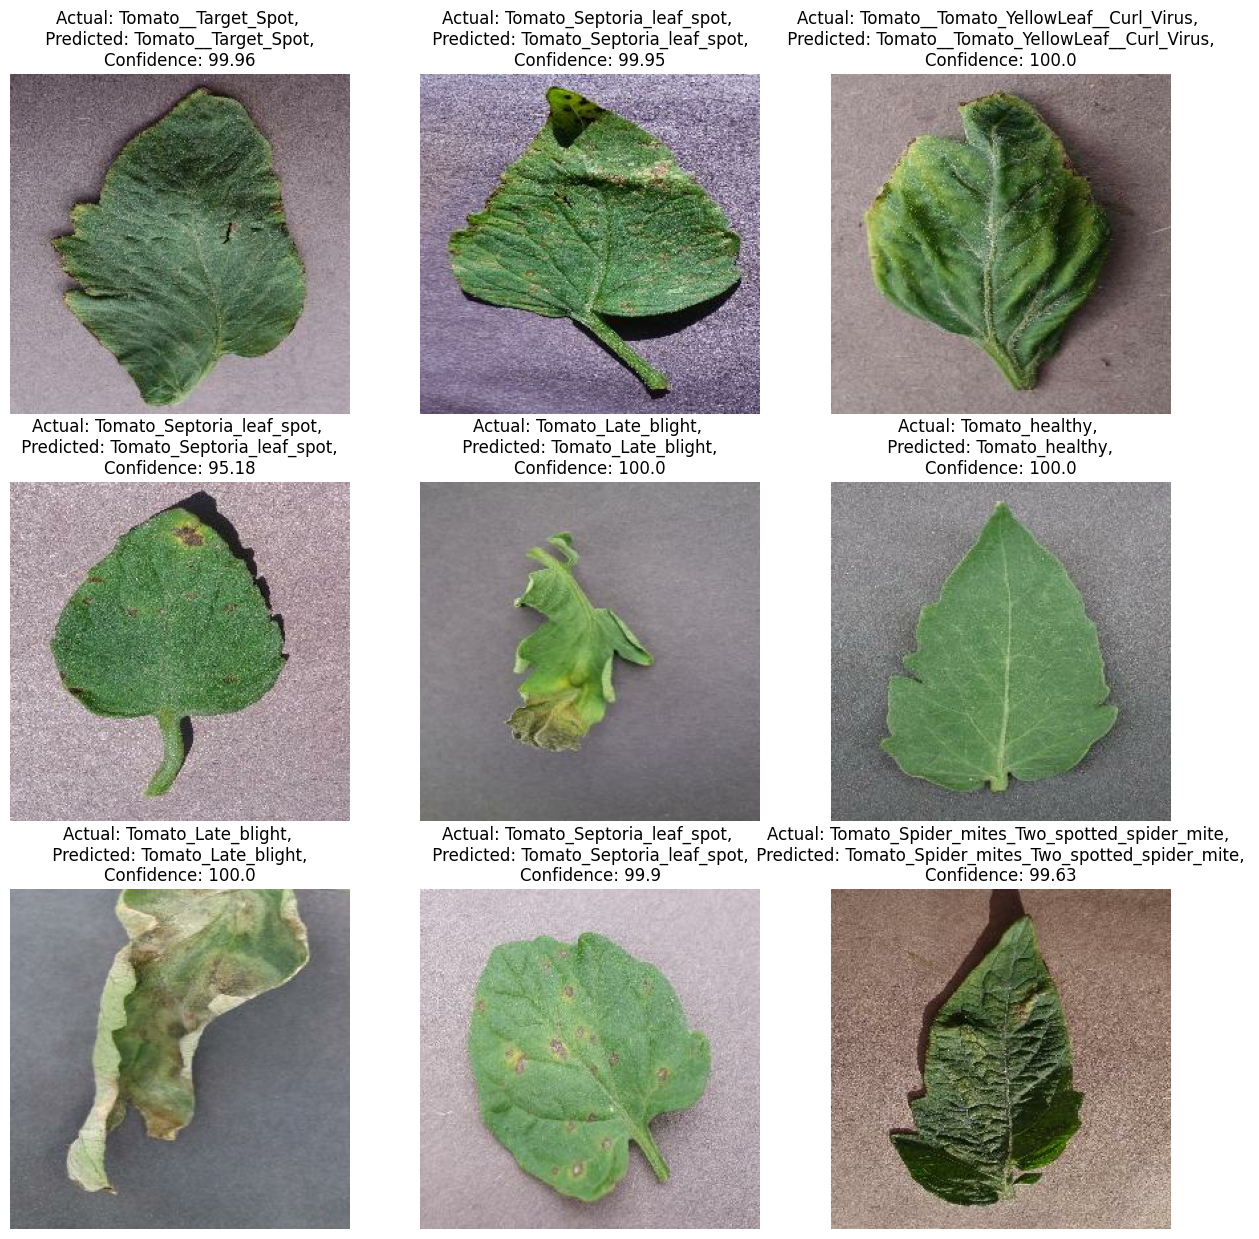

In [18]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \nConfidence: {confidence}')
        plt.axis('off')

In [19]:
model.save('C:/Users/gotze/OneDrive/Desktop/Python/Deep Learning/Project/Models/Model3_Tomatoes.keras')